In [99]:
import json
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import clip
from PIL import Image
import PIL
from IPython.display import display

from fine_tune import MyDataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [106]:
trainset_font_name_path = '../dataset/fontset/trainset'
tag_label_dir = '../dataset/taglabel'
with open(trainset_font_name_path, 'r') as f:
    tmp_font_names = f.read().split('\n')
font_names = []
font_name_to_tag_label = {}
for font_name in tmp_font_names:
    if font_name != '':
        font_name = font_name.replace(' ', '')
        tag_label_path = os.path.join(tag_label_dir, font_name)
        with open(tag_label_path, 'r') as f:
            tmp_tag_label = f.read().split(' ')
        tag_label = []
        for tag in tmp_tag_label:
            if tag not in [' ', '\n', '']:
                tag_label.append(tag)
        if tag_label:
            font_name_to_tag_label[font_name] = tag_label
            font_names.append(font_name)

In [109]:
class LargeDataset(Dataset):
    @staticmethod
    def adjust_font_image_size(image: PIL.Image):
        width, height = image.size
        new_size = (max(width, height), max(width, height))
        new_image = Image.new('RGB', new_size, (255, 255, 255))

        #x_offset = 0 if width > height else int((height - width) / 2)
        x_offset = int((width - height) / 2)
        y_offset = 0 if width < height else int((width - height) / 2)
        new_image.paste(image, (x_offset, y_offset))

        return new_image


    def generate_multiple_attributes_prompt(self, tags, sample_tag_num):
        return MyDataset.generate_multiple_attributes_prompt(tags, use_random=True, max_sample_num=sample_tag_num)

    def load_and_dump_image_tensor(self, font_name, char):
        image_path = os.path.join(self.image_file_dir, f'{font_name}_{char}.png')
        image = Image.open(image_path)
        adjusted_image = self.adjust_font_image_size(image)
        return self.preprocess(adjusted_image)

    def __init__(self, font_names, font_name_to_tag_label, used_chars=None, sample_tag_num=5, sample_query_num=10, preprocess=preprocess, image_file_dir='../dataset/fontimage'):
        self.font_names = font_names
        self.font_name_to_tag_label = font_name_to_tag_label
        self.preprocess = preprocess
        self.used_chars = used_chars
        self.image_file_dir = image_file_dir
        self.sample_tag_num = sample_tag_num

        if self.used_chars is None:
            self.used_chars = ['AA']

        # create queries
        self.font_to_queries = {}
        for font_name in self.font_names:
            tags = self.font_name_to_tag_label[font_name]
            queries = [clip.tokenize(self.generate_multiple_attributes_prompt(tags, self.sample_tag_num)) for _ in range(sample_query_num)]
            self.font_to_queries[font_name] = queries

        # create images
        self.font_to_image_tensors = {}
        for font_name in self.font_names:
            images = []
            for char in self.used_chars:
                image = self.load_and_dump_image_tensor(font_name, char)
                images.append(image)
            self.font_to_image_tensors[font_name] = images

    def __len__(self):
        return len(self.font_names)

    def __getitem__(self, idx):
        font_name = self.font_names[idx]
        query = random.choice(self.font_to_queries[font_name])
        image = random.choice(self.font_to_image_tensors[font_name])
        return query, image

In [110]:
dataset = LargeDataset(font_names, font_name_to_tag_label)

In [111]:
it = DataLoader(dataset, batch_size=8, shuffle=True)

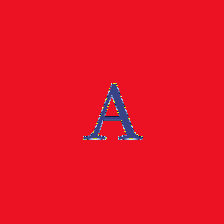

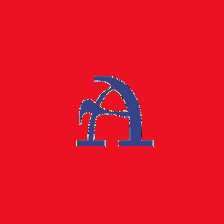

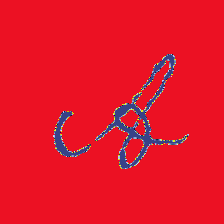

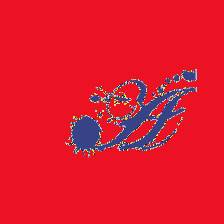

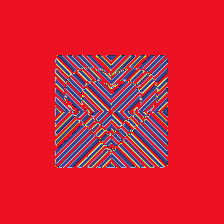

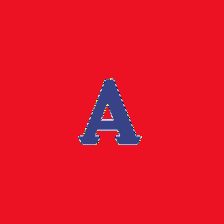

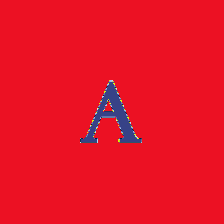

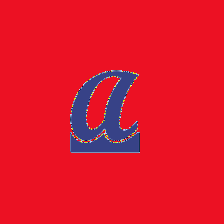

In [114]:
for queries, images in it:
    for query, image in zip(queries, images):
        display(to_pil_image(image))
    break